In [ ]:
# !pip install folium==0.13.0

In [1]:
import pandas as pd
import os
import math
import requests as rq
import folium
from IPython.display import display
from IPython.display import Image
from folium import plugins
import numpy

In [3]:
#parkdf.csv, tourlist.csv 가져오기
park_df = pd.read_csv(r'./data/parkdf.csv', encoding='cp949') #주차장 데이터
tourlist_df = pd.read_csv(r'./data/tourlist.csv', encoding = "cp949")

In [4]:
tourlist_df

,관광지명,주소,분류,위도,경도
0,더현대서울,서울 영등포구 여의대로 108-0,백화점,37.526050,126.928296
1,코엑스,서울 강남구 영동대로 513-0,전시시설,37.512521,127.058819
2,신세계백화점강남점,서울 서초구 신반포로 176-0,백화점,37.504364,127.003621
3,가락동농수산물도매시장,서울 송파구 양재대로 932-0,시장,37.493482,127.111504
4,타임스퀘어,서울 영등포구 영중로 15-0,쇼핑몰,37.517075,126.903341
...,...,...,...,...,...
67,북서울꿈의숲,서울 강북구 월계로 173-0,도시공원,37.621771,127.041174
68,잠실한강공원,서울 송파구 한가람로 65-0,도시공원,37.518507,127.083144
69,롯데백화점에비뉴엘월드타워점,서울 송파구 올림픽로 300-0,백화점,37.513101,127.103433
70,고척스카이돔,서울 구로구 경인로 430-0,레저스포츠시설,37.498931,126.867087


### 두 점 사이의 거리를 구하는 것은 피타고라스 정리를 사용하면 된다.
### 하지만 지구는 둥글기 때문에 하버사인(haversine)공식을 활용해서 정확한 거리를 구한다.

In [ ]:
google_api_key = ''
# url = 'https://maps.googleapis.com/maps/api/geocode/outputFormat?parameters' 

In [6]:
def get_latitude_longitude(address): # 주소를 가지고 위도, 경도를 알아내기
    url = f'https://maps.googleapis.com/maps/api/geocode/json?address={address}&key={google_api_key}'
    response = response = rq.get(url)
    if response.status_code == 200:
        results = response.json()
        if results['status'] == 'OK': #results status가 OK인지 확인
            latitude = results['results'][0]['geometry']['location']['lat']
            longitude = results['results'][0]['geometry']['location']['lng']
            return latitude, longitude
    return None, None

In [7]:
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371.0 #지구 반지름(km 단위)

    #삼각함수 활용을 위해 위도와 경도를 라디안으로 변환한다.
    rad_lat1 = math.radians(lat1)
    rad_lon1 = math.radians(lon1)
    rad_lat2 = math.radians(lat2)
    rad_lon2 = math.radians(lon2)

    #각 위도와 경도의 차이를 계산한다.
    dt_lat = rad_lat2 - rad_lat1
    dt_lon = rad_lon2 - rad_lon1

    #하버사인 공식 계산
    a = math.sin(dt_lat / 2)**2 + math.cos(rad_lat1) * math.cos(rad_lat2) * math.sin(dt_lon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # 두 지점 간 거리
    distance = R * c * 1000 # (km -> m로 변환)
    return distance 

## **추천 점수**
<hr>
- 관광지 아닐 경우
    추천점수 = (1 + (최대거리 - 목적지와 주차장 간 거리) / 최대거리)*감점계수
    감점계수 = 1
    
    해당 주차장 주변(0.5km)이내에 관광지가 있는 경우:
        (1 + (최대거리 - 목적지와 주차장 간 거리) / 최대거리)*감점 계수
        감점계수 = 0.7
    목적지와 주차장 간 거리 = 주차장이 목적지에 가까울수록 추천 점수가 높아진다.
    최대거리 = 주차장과 목적지 간 거리가 최대거리 이내여야 함 (3km)

- 관광지일 경우 : 주차장과 사용자 간의 거리가 너무 가까우면(0.5km미만) 점수 감점
  
    추천점수 = (1 + (최대거리 - 목적지와 주차장 간 거리) / 최대거리)

In [8]:
def check_is_tourlist_spot(dest_lat, dest_lon):#현재 목적지가 관광지인지 확인
    for lat, lon in zip(tourlist_df['위도'], tourlist_df['경도']):
        if lat == dest_lat and lon == dest_lon:
            return True
    return False   

In [9]:
def check_tourlist_park_distance(lat2, lon2): #해당 위도, 경도가 관광지랑 500m내일때
    for index, row in tourlist_df.iterrows():
        if haversine_distance(lat2, lon2, row['위도'], row['경도']) <= 500:
            return True
    return False

In [10]:
#현재 사용자와 주차장 간 거리를 구하고 추천 점수 만들기(하버사인 공식 사용)
def get_recommend_score(lat1, lon1, lat2, lon2, dest_lat, dest_lon):
    if check_is_tourlist_spot(dest_lat, dest_lon): #목적지가 관광지인지 확인
        distance_to_attraction = haversine_distance(lat2, lon2, dest_lat, dest_lon) #주차장과 목적지(관광지)와의 거리
        recommend_score = ((1500 - distance_to_attraction) / 1500) * 100
    else:
        distance_to_destination = haversine_distance(lat2, lon2, dest_lat, dest_lon) #주차장과 목적지와의 거리
        penalty = 1
        if check_tourlist_park_distance(lat2, lon2):
            penalty = 0.7
        recommend_score = ((1500 - distance_to_destination) / 1500)*100*penalty
    return recommend_score

In [11]:
address = input("현재 위치 주소를 입력하세요 : ")
lat1, lon1 = get_latitude_longitude(address)
if (lat1 == None) | (lon1 == None): #잘못된 현재 위치 정보
    print("잘못된 주소입니다. 다시 입력해 주세요.")

    
dest_address = input("목적지 주소를 입력하세요 : ")
#google map으로 목적지의 위도, 경도를 확인한다.
dest_lat, dest_lon = get_latitude_longitude(dest_address)
if (dest_lat is None) | (dest_lon is None): #잘못된 목적지 정보
    print("잘못된 목적지 정보입니다. 다시 입력해 주세요.")


recommend_park = park_df[['주차장명', '위도', '경도']]    
    

#목적지에서 1.5km이내인 주차장을 필터링
recommend_park = recommend_park[recommend_park.apply(lambda row : haversine_distance(dest_lat, dest_lon, row['위도'], row['경도']) <= 1500, axis = 1)]

recommend_park['점수'] = recommend_park.apply(lambda row: get_recommend_score(lat1, lon1, row['위도'], row['경도'], dest_lat, dest_lon), axis = 1)

top_5 = recommend_park.sort_values(by='점수', ascending = False).head(5)
top_5.index = [1,2,3,4,5]
print(top_5)
#지도 생성
my_map = folium.Map(location = [dest_lat, dest_lon], zoom_start=13)

#현재 위치 마커 추가
folium.Marker([lat1, lon1], popup = "내 위치", icon = folium.Icon(color = 'black', icon = 'home')).add_to(my_map)
#목적지 마커 추가
folium.Marker([dest_lat, dest_lon], popup = "목적지", icon = folium.Icon(color = 'green', icon = 'flag')).add_to(my_map)
folium.Circle([dest_lat, dest_lon], radius = 1500, color = "green", fill = True).add_to(my_map)
#관광지 범위원으로 추가
for index, row in tourlist_df.iterrows():
    folium.Circle([row["위도"], row["경도"]], radius = 500, color = "red", fill = True).add_to(my_map)
    folium.Marker([row["위도"], row["경도"]], popup = row["관광지명"], icon = folium.Icon(color = "red", icon = 'star')).add_to(my_map)

#추천 주차장 마커 추가
for index, row in top_5.iterrows():
    folium.Marker(
        [row['위도'], row['경도']],
        popup = row['주차장명'],
        icon =  plugins.BeautifyIcon(icon_shape="circle", number = index, icon_size =(25,25), background_color = "blue", text_color = "white")
    ).add_to(my_map)
display(my_map)
    

현재 위치 주소를 입력하세요 :  여의도
목적지 주소를 입력하세요 :  서울특별시교육청융합과학교육원 남산분원


                       주차장명         위도          경도         점수
1            남산파출소 공영주차장(시)  37.555162  126.982775  87.031762
2           남산케이블카 공영주차장(시)  37.555758  126.983836  79.591341
3            남산소파길 공영주차장(시)  37.557172  126.986052  63.146969
4  공유) 회현동 12(005~013구간)(구)  37.554569  126.973885  60.037559
5        서소문 삼성생명뒤 공영주차장(구)  37.561552  126.975077  38.822303


위치 : (37.52958080000001, 126.9326803) (여의도)
목적지 : (37.5545994, 126.9806853) (서울특별시교육청융합과학교육원 남산분원)

<hr>

## **나의 위치와 추천 주차장 간의 최단 경로 구하기**

## OSMnx 활용해서 파이썬 도로 네트워크 분석하기
OSMnx : OpenStreetMap의 도로망 데이터를 기반으로 네트워크 분석 등을 할 수 있도록 만든 파이썬 라이브러리 https://www.openstreetmap.org/

In [ ]:
!pip install osmnx

In [ ]:
!pip install descartes

In [13]:
import osmnx as ox, networkx as nx, geopandas as gdp, matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, LineString
from descartes import PolygonPatch
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
ox.settings.use_cache = True
ox.settings.log_console = True
ox.__version__

'1.9.4'

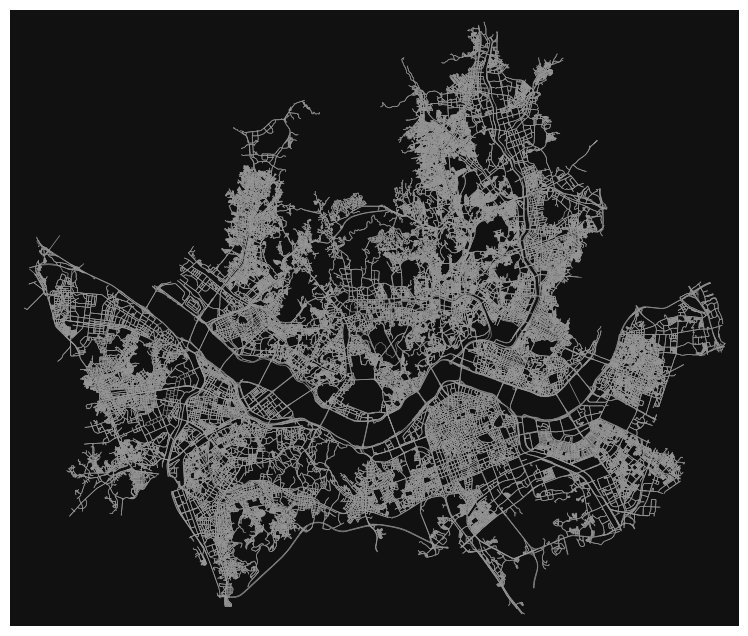

In [14]:
G = ox.graph_from_place('서울특별시, 대한민국', network_type = 'drive', simplify = False)
fig, ax = ox.plot_graph(G, figsize = (12,8), node_size = 0, edge_linewidth = 0.5)

In [21]:
G_proj = ox.project_graph(G)

오픈스트리트맵의 좌표계를 맞춰준다. 경도 -> 위도 순서로 써야함

In [22]:
orig_coords = (37.52958080000001, 126.9326803) #현재 위치(여의도)
dest_coords = (37.555162 , 126.982775) #추천 주차장(남산파출소 공영주차장)

In [23]:
orig_node = ox.distance.nearest_nodes(G, orig_coords[1], orig_coords[0]) #경도 -> 위도 순서로 써야함
dest_node = ox.distance.nearest_nodes(G, dest_coords[1], dest_coords[0])

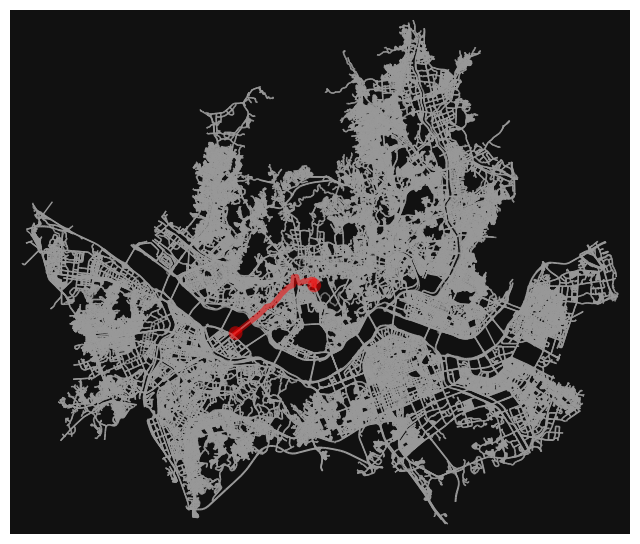

In [24]:
#최단거리 분석하기 위한 라이브러리 (거리 기반 최단거리)
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
mpl.rc('font', family='NanumGothic') #한글 폰트 적용(NanumGothic 설치)
plt.rcParams["figure.figsize"] = (20,20) #차트 사이즈

#최단거리 분석하고 그 결과 시각화
route = nx.shortest_path(G, orig_node, dest_node, weight='length')
fig, ax = ox.plot_graph_route(G, route, route_color = 'r', route_linewidth = 4, node_size=0)

### OSM 네트워크 분석 결과를 Folium map에 시각화

In [25]:
from IPython.display import IFrame

In [ ]:
route_graph_map = ox.plot_route_folium(G, route, route_map = my_map, popup_attribute = 'length')
graph_path ='./data/route_graph_map.html'
route_graph_map.save(graph_path)
IFrame(graph_path, width=600, height = 500)